In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchmetrics.functional as evafunc
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
import segmentation_models_pytorch as smp
import os
import imp
import CTimageLIB
imp.reload(CTimageLIB)
from PIL import Image

c:\Users\manjw\.conda\envs\dataEngineering\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\manjw\.conda\envs\dataEngineering\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\manjw\AppData\Local\Temp\ipykernel_17244\3418379195.py:16: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
# 自定义数据集类
class SpineWeb15(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        file_list = os.listdir(self.data_path)  # 列出文件夹中的所有文件和文件夹
        file_count = len(file_list)  # 获取文件数量
        return file_count
    
    def __getitem__(self, index):
        metadata = np.load(self.data_path+str(index)+".npy")
        image = metadata[0]
        label = metadata[1]

        image_data = torch.from_numpy(image).float()
        label_data = torch.from_numpy(label).float()
        
        if self.transform:
            image_data = self.transform(image_data)
            label_data = self.transform(label_data)
        return image_data, label_data


In [3]:
def calculate_pixel_accuracy(prediction, target):
    # 将预测结果和目标标签进行逐像素比较，并计算正确预测像素的比例
    correct_pixels = (prediction == target).sum()
    total_pixels = target.size
    return correct_pixels, total_pixels

def calculate_iou(pred, target):
    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice(pred, target):
    intersection = np.logical_and(pred, target)
    dice_score = 2 * np.sum(intersection) / (np.sum(pred) + np.sum(target))
    return dice_score

def visualize_results(image,label,output):
    fig, axes = plt.subplots(3, 1)
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('image')
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title('label')
    axes[2].imshow(output, cmap='gray')
    axes[2].set_title('output')
    plt.tight_layout()
    plt.show()


In [4]:
# find the point overlap frequently

# empty the cache for model and training process
torch.cuda.empty_cache()

# set the hyper parameters and the paths 设置超参数和路径
data_path = "./dataset/Spineweb_dataset15/test_1/"    # the path of the dataset
file_list = os.listdir(data_path)  # list all files and folders in the folder(data path)
file_count = len(file_list)  # get the numer of files
print("Length of the dataset:",file_count)
resize_scale = (128,128)    # set the resize scale for images
print("----------------  Loading the dataset and evaluate  ----------------")
data_count = 0
poster_threshold = 200

cal_matrix = np.zeros((128,128))

for index in range(file_count):     # iterate the whole dataset
    metadata = np.load(data_path+str(index)+".npy")     # load the data
    image = np.array(Image.fromarray(metadata[0]).resize(resize_scale))     # Using the PIL to resize the transfer into npy again
    label = Image.fromarray((metadata[1] * 255).astype('uint8')).resize(resize_scale)     # Using the PIL to resize the transfer into npy again
    label = np.array(label)
    label[label < poster_threshold] = 0
    label[label >= poster_threshold] = 1
    cal_matrix += (label == 1).astype(np.int32)

print(cal_matrix)

array = cal_matrix

# 直接找到最大元素的索引
max_index = np.unravel_index(np.argmax(array), array.shape)

# 输出最大元素的索引
print("The index of maximum element：", max_index)
print("The value of maximum element:", array[max_index])
    

Length of the dataset: 365
----------------  Loading the dataset and evaluate  ----------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The index of maximum element： (77, 57)
The value of maximum element: 281.0


In [10]:
# -----------------------------
# Region growing method application
# -----------------------------

# empty the cache for model and training process
torch.cuda.empty_cache()

# Do the segmentation to exteract the spine part
# set the threshold and the seed point for the region growing method
seed_point = max_index

final_acc = 0.0
final_dice = 0.0
final_iou = 0.0
best_threshold = 0

# set the hyper parameters and the paths 设置超参数和路径
data_path = "./dataset/Spineweb_dataset15/test_1/"    # the path of the dataset
file_list = os.listdir(data_path)  # list all files and folders in the folder(data path)
file_count = len(file_list)  # get the numer of files
print("Length of the dataset:",file_count)
resize_scale = (128,128)    # set the resize scale for images
print("----------------  Loading the dataset and evaluate  ----------------")
poster_threshold = 200

for threshold in range(50,400,10):
    # the variables for evaluation
    total_correct_pixels = 0
    total_pixels = 0
    total_iou = 0.0
    total_dice = 0.0

    data_count = 0
    for index in range(file_count):     # iterate the whole dataset
        metadata = np.load(data_path+str(index)+".npy")     # load the data
        image = np.array(Image.fromarray(metadata[0]).resize(resize_scale))     # Using the PIL to resize the transfer into npy again
        label = Image.fromarray((metadata[1] * 255).astype('uint8')).resize(resize_scale)     # Using the PIL to resize the transfer into npy again
        label = np.array(label)
        label[label < poster_threshold] = 0
        label[label >= poster_threshold] = 1
        
        # print(type(image),image.shape,image)
        # print(type(label),label.shape,label)
        output = CTimageLIB.regionGrowing(image, seed_point, threshold)
        # evaluations
        current_correct_pixels,current_pixels = calculate_pixel_accuracy(output,label)
        current_iou = calculate_iou(output,label)
        current_dice = calculate_dice(output,label)
        # add the results to total one
        total_correct_pixels += current_correct_pixels
        total_pixels += current_pixels
        total_iou += current_iou
        total_dice += current_dice
        data_count += 1

    temp_acc = total_correct_pixels/total_pixels
    temp_iou = total_iou/data_count
    temp_dice = total_dice/data_count

    print(f"Threshold: {threshold:.1f}, Best IoU: {temp_iou:.4f}, Best Dice: {temp_dice:.4f}, Best Acc: {temp_acc:.4f}")

    final_acc = final_acc if final_acc > temp_acc else temp_acc
    final_iou = final_iou if final_iou > temp_iou else temp_iou
    if temp_dice > final_dice:
        final_dice = temp_dice
        best_threshold = threshold


print("---------------------------------------------------------------------------")
print(f"Best IoU: {final_iou:.4f}, Best Dice: {final_dice:.4f}, Best Acc: {final_acc:.4f}")
print("Most overlap point:",max_index)
print("Best threshold:",best_threshold)


Length of the dataset: 365
----------------  Loading the dataset and evaluate  ----------------
Threshold: 50.0, Best IoU: 0.0474, Best Dice: 0.0047, Best Acc: 0.8954
Threshold: 60.0, Best IoU: 0.0614, Best Dice: 0.0048, Best Acc: 0.8700
Threshold: 70.0, Best IoU: 0.0735, Best Dice: 0.0047, Best Acc: 0.8422
Threshold: 80.0, Best IoU: 0.0839, Best Dice: 0.0045, Best Acc: 0.8215
Threshold: 90.0, Best IoU: 0.0935, Best Dice: 0.0045, Best Acc: 0.8002
Threshold: 100.0, Best IoU: 0.1006, Best Dice: 0.0044, Best Acc: 0.7822
Threshold: 110.0, Best IoU: 0.1124, Best Dice: 0.0044, Best Acc: 0.7634
Threshold: 120.0, Best IoU: 0.1203, Best Dice: 0.0043, Best Acc: 0.7422
Threshold: 130.0, Best IoU: 0.1284, Best Dice: 0.0043, Best Acc: 0.7208
Threshold: 140.0, Best IoU: 0.1340, Best Dice: 0.0043, Best Acc: 0.7040
Threshold: 150.0, Best IoU: 0.1430, Best Dice: 0.0043, Best Acc: 0.6845
Threshold: 160.0, Best IoU: 0.1440, Best Dice: 0.0041, Best Acc: 0.6629
Threshold: 170.0, Best IoU: 0.1418, Best Dice

Length of the dataset: 3005
----------------  Loading the dataset and evaluate  ----------------


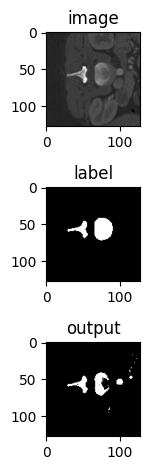

Best IoU: 0.4236, Best Dice: 0.5625, Best Acc: 0.9506


In [19]:
# -----------------------------
# Threshold method application
# -----------------------------

# empty the cache for model and training process
torch.cuda.empty_cache()

# Do the segmentation to exteract the spine part
# Threshold segmentation hyper parameters
minThreshold = 250
maxThreshold = 1500

# the variables for evaluation
total_correct_pixels = 0
total_pixels = 0
total_iou = 0.0
total_dice = 0.0

# set the hyper parameters and the paths 设置超参数和路径
data_path = "./dataset/Spineweb_dataset15/train/"    # the path of the dataset
file_list = os.listdir(data_path)  # list all files and folders in the folder(data path)
file_count = len(file_list)  # get the numer of files
print("Length of the dataset:",file_count)
resize_scale = (128,128)    # set the resize scale for images
print("----------------  Loading the dataset and evaluate  ----------------")
data_count = 0
poster_threshold = 200
for index in range(file_count):     # iterate the whole dataset
    metadata = np.load(data_path+str(index)+".npy")     # load the data
    image = np.array(Image.fromarray(metadata[0]).resize(resize_scale))     # Using the PIL to resize the transfer into npy again
    label = Image.fromarray((metadata[1] * 255).astype('uint8')).resize(resize_scale)     # Using the PIL to resize the transfer into npy again
    label = np.array(label)
    label[label < poster_threshold] = 0
    label[label >= poster_threshold] = 1
    
    # print(type(image),image.shape,image)
    # print(type(label),label.shape,label)
    output = CTimageLIB.thresholdSegmentation(image,minThreshold,maxThreshold)
    # evaluations
    current_correct_pixels,current_pixels = calculate_pixel_accuracy(output,label)
    current_iou = calculate_iou(output,label)
    current_dice = calculate_dice(output,label)
    # add the results to total one
    total_correct_pixels += current_correct_pixels
    total_pixels += current_pixels
    total_iou += current_iou
    total_dice += current_dice
    data_count += 1
    # visualize the results
    if index == 100:
        visualize_results(image,label,output)

final_acc = total_correct_pixels/total_pixels
final_iou = total_iou/data_count
final_dice = total_dice/data_count

print(f"Best IoU: {final_iou:.4f}, Best Dice: {final_dice:.4f}, Best Acc: {final_acc:.4f}")
